In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("mortgage_data_with_risk_categories.csv")

# === Ordinal Encoding ===
# Education Level
education_level_map = {
    'No certificate, diploma or degree': 1,
    'High school diploma or equivalent': 2,
    'Trades or apprenticeship certificate': 3,
    'College or CEGEP certificate or diploma': 4,
    'University transfer program': 5,
    'University certificate or diploma below a bachelor\'s degree': 6,
    'Bachelor\'s degree': 7,
    'University certificate or diploma above a bachelor\'s degree': 8,
    'First professional degree': 9,
    'Master\'s degree': 10,
    'Doctoral degree': 11
}
df['education_level'] = df['education_level'].map(education_level_map)

# Marital Status
marital_status_map = {
    'Single': 3,
    'Married': 2,
    'Divorced': 1,
    'Widowed': 1
}
df['marital_status'] = df['marital_status'].map(marital_status_map)

# Immigration Status
immigration_status_map = {
    'Canadian-born': 3,
    'Long-term immigrant': 2,
    'Recent immigrant': 1
}
df['immigration_status'] = df['immigration_status'].map(immigration_status_map)

# Industry Sector
industry_sector_map = {
    'Tech': 10,
    'Finance': 9,
    'Healthcare': 8,
    'Education': 7,
    'Manufacturing': 6,
    'Retail': 5,
    'Logistics': 4,
    'Construction': 3,
    'Manual Labor': 2,
    'Other': 1,
}
df['industry_sector'] = df['industry_sector'].map(industry_sector_map)

# Employment Status
employment_status_map = {
    'Student': 1,
    'Unemployed': 1,
    'Self-employed': 2,
    'Retired': 2,
    'Employed': 3
}
df['employment_status'] = df['employment_status'].map(employment_status_map)

# Income Type
income_type_map = {
    'Hourly': 1,
    'Contract': 2,
    'Salaried': 3
}
df['income_type'] = df['income_type'].map(income_type_map)

# === Select Only Important Features for Stress Testing ===
selected_features = [
    'age',
    'immigration_status',
    'education_level',
    'industry_sector',
    'annual_income',
    'total_years_employment',
    'years_with_current_employer',
    'credit_score',
    'delinquencies_past_12mo',
    'credit_utilization',
    'number_of_open_loans',
    'total_value_of_open_loans',
    'assets',
    'liquid_assets',
    'net_worth',
    'total_liabilities',
    'mortgage_amount',
    'mortgage_start_year',
    'interest_rate',
    'loan_to_value',
    'monthly_payment',
    'property_value'
]

df_selected = df[selected_features].copy()

# === Final Checks ===
print("Shape after selection:", df_selected.shape)
print("\nMissing values:\n", df_selected.isna().sum())
print("\nSample:\n", df_selected.head())


Shape after selection: (10000, 22)

Missing values:
 age                            0
immigration_status             0
education_level                0
industry_sector                0
annual_income                  0
total_years_employment         0
years_with_current_employer    0
credit_score                   0
delinquencies_past_12mo        0
credit_utilization             0
number_of_open_loans           0
total_value_of_open_loans      0
assets                         0
liquid_assets                  0
net_worth                      0
total_liabilities              0
mortgage_amount                0
mortgage_start_year            0
interest_rate                  0
loan_to_value                  0
monthly_payment                0
property_value                 0
dtype: int64

Sample:
    age  immigration_status  education_level  industry_sector  annual_income  \
0   24                   1                7                4      101293.41   
1   21                   3              

In [53]:
# Initialize scenario cluster columns
df['cluster_job_automation'] = np.nan
df['cluster_immigrant_flow'] = np.nan
df['cluster_supply_chain'] = np.nan

# --- Scenario 1: Job Loss Due to Automation ---
df['cluster_job_automation'] = np.nan
df.loc[df['industry_sector'] == 2, 'cluster_job_automation'] = 1   # Manual Labor
df.loc[df['industry_sector'] == 10, 'cluster_job_automation'] = 2  # Tech
df.loc[df['industry_sector'].isin([9, 8, 7, 5, 1]), 'cluster_job_automation'] = 3  # Finance, Healthcare, Education, Retail, Other
df['cluster_job_automation'] = df['cluster_job_automation'].fillna(4) # Assign cluster 4 to any unclassified industry sectors

# --- Scenario 2: Immigrant Inflow Decrease ---
df['cluster_immigrant_flow'] = np.nan
df.loc[df['immigration_status'].isin([1, 2]), 'cluster_immigrant_flow'] = 1  # Recent + Long-term immigrants
df.loc[df['immigration_status'] == 3, 'cluster_immigrant_flow'] = 2         # Canadian-born

# --- Scenario 3: Supply Chain Disruption ---
df['cluster_supply_chain'] = np.nan
df.loc[df['industry_sector'].isin([4, 6]), 'cluster_supply_chain'] = 1  # Logistics + Manufacturing
df.loc[df['industry_sector'].isin([3, 2]), 'cluster_supply_chain'] = 2  # Construction + Manual Labor
df.loc[df['industry_sector'].isin([10, 9, 8, 7, 5, 1]), 'cluster_supply_chain'] = 3  # Others

# Show value counts of each scenario's clusters (to check how many NaNs were filled)
automation_counts = df['cluster_job_automation'].value_counts(dropna=False)
immigrant_counts = df['cluster_immigrant_flow'].value_counts(dropna=False)
supply_chain_counts = df['cluster_supply_chain'].value_counts(dropna=False)

print(automation_counts, immigrant_counts, supply_chain_counts)

cluster_job_automation
3.0    4470
4.0    2564
2.0    1486
1.0    1480
Name: count, dtype: int64 cluster_immigrant_flow
2.0    7929
1.0    2071
Name: count, dtype: int64 cluster_supply_chain
3.0    5956
2.0    2545
1.0    1499
Name: count, dtype: int64


In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_decomposition import PLSRegression

def visualize_lda(df, cluster_col, features, title):
    df_filtered = df[df[cluster_col].notnull()]
    X = df_filtered[features]
    y = df_filtered[cluster_col]

    n_classes = len(np.unique(y))
    n_components = min(X.shape[1], n_classes - 1)

    lda = LDA(n_components=n_components)
    lda_components = lda.fit_transform(X, y)

    if n_components == 1:
        lda_df = pd.DataFrame({
            'LD1': lda_components[:, 0],
            'Cluster': y.astype(int)
        })
        plt.figure(figsize=(10, 4))
        sns.histplot(data=lda_df, x='LD1', hue='Cluster', bins=30, kde=True, palette='Set2', element='step')
        plt.title(title)
        plt.xlabel("Linear Discriminant 1")
        plt.ylabel("Density")
    else:
        lda_df = pd.DataFrame({
            'LD1': lda_components[:, 0],
            'LD2': lda_components[:, 1],
            'Cluster': y.astype(int)
        })
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Cluster', palette='Set2')
        plt.xlabel("Linear Discriminant 1")
        plt.ylabel("Linear Discriminant 2")

    plt.title(title)
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

def visualize_pls_clusters(df, cluster_col, features, title):
    # Drop rows with missing cluster assignments
    df_filtered = df[df[cluster_col].notnull()]
    
    X = df_filtered[features]
    y = df_filtered[cluster_col].astype(int)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PLS (2 components for 2D plotting)
    pls = PLSRegression(n_components=2)
    X_pls = pls.fit_transform(X_scaled, y)[0]  # First element is the transformed X

    # Create DataFrame for plotting
    pls_df = pd.DataFrame({
        'PLS1': X_pls[:, 0],
        'PLS2': X_pls[:, 1],
        'Cluster': y
    })

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pls_df, x='PLS1', y='PLS2', hue='Cluster', palette='Set2')
    plt.title(f"{title} (PLS Visualization)")
    plt.xlabel('PLS Component 1')
    plt.ylabel('PLS Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

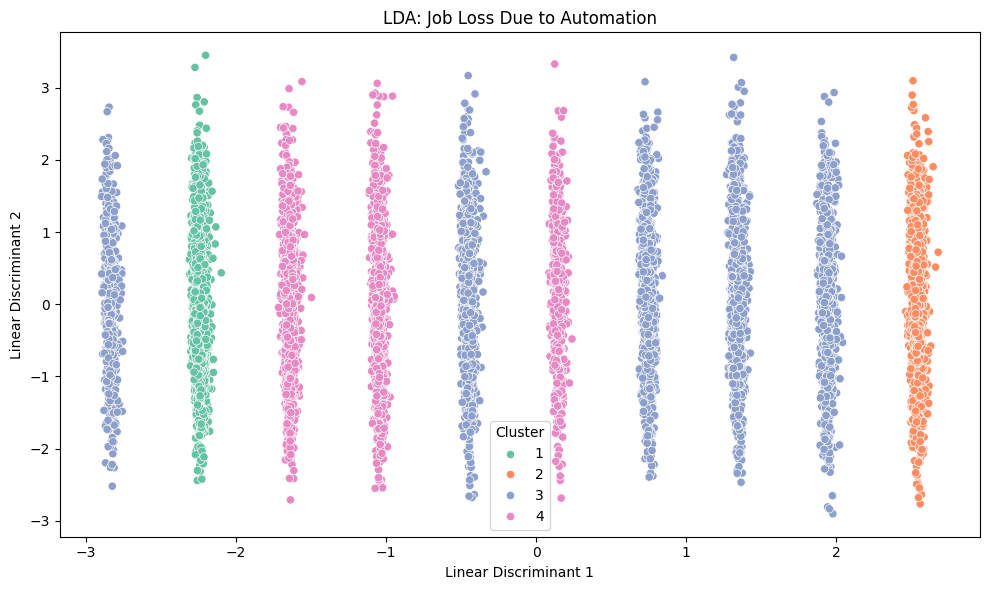

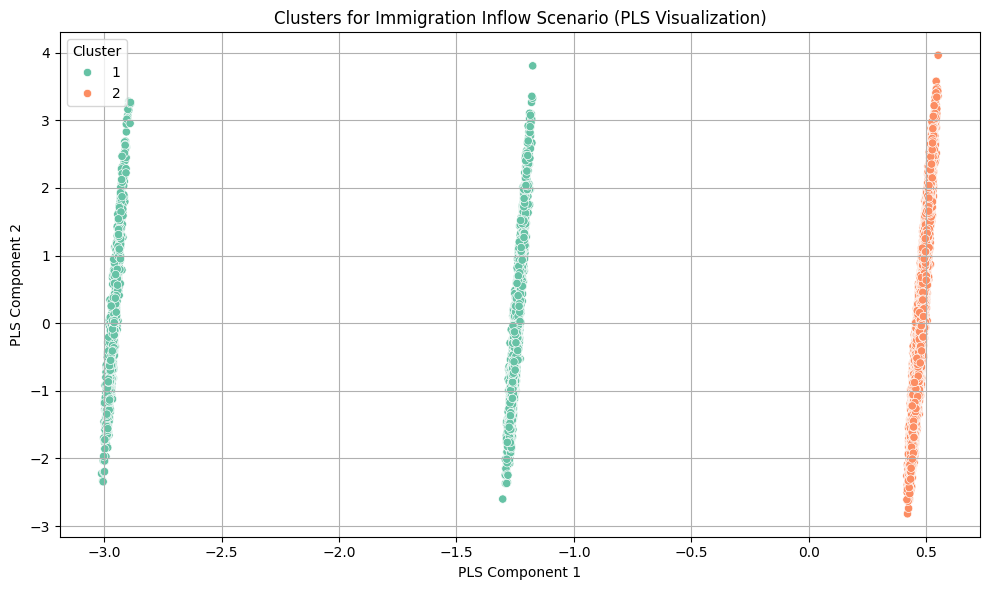

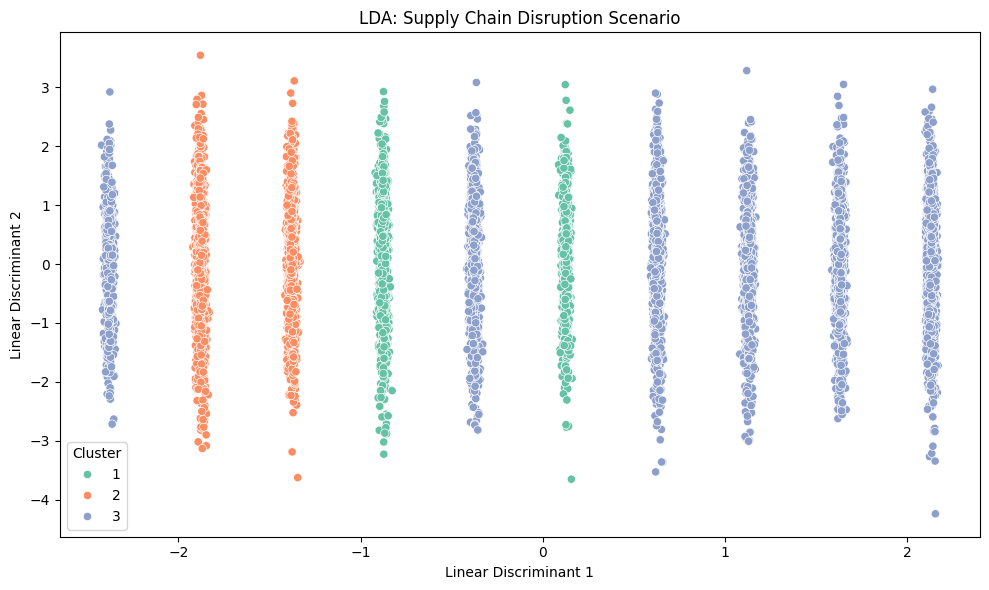

In [55]:
# Define feature subset
features_automation = [
    'age', 'education_level', 'industry_sector', 'employment_status',
    'annual_income', 'credit_score', 'total_years_employment', 'years_with_current_employer'
]

# Call for Job Loss Due to Automation
visualize_lda(df, 'cluster_job_automation', features_automation, 'LDA: Job Loss Due to Automation')

features_immigrant = [
    'age', 'immigration_status', 'education_level', 'annual_income',
    'credit_score', 'total_years_employment', 'net_worth', 'total_liabilities'
]

visualize_pls_clusters(df, 'cluster_immigrant_flow', features_immigrant, 'Clusters for Immigration Inflow Scenario')

features_supply_chain = [
    'industry_sector', 'employment_status', 'annual_income', 'credit_score',
    'loan_to_value', 'mortgage_amount', 'monthly_payment', 'assets'
]

visualize_lda(df, 'cluster_supply_chain', features_supply_chain, 'LDA: Supply Chain Disruption Scenario')

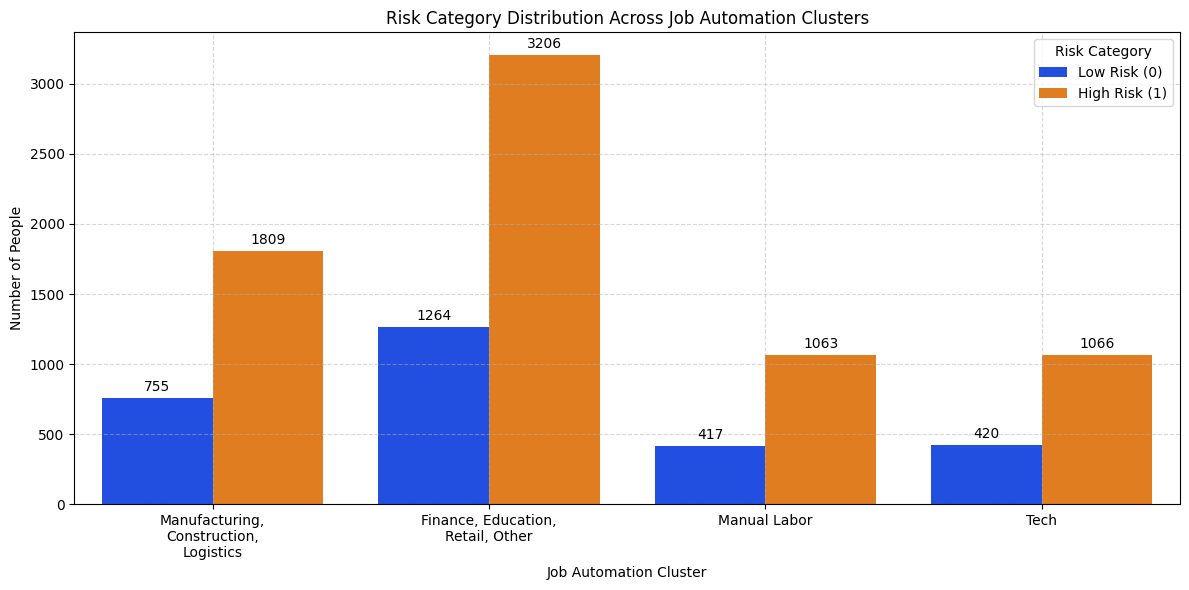

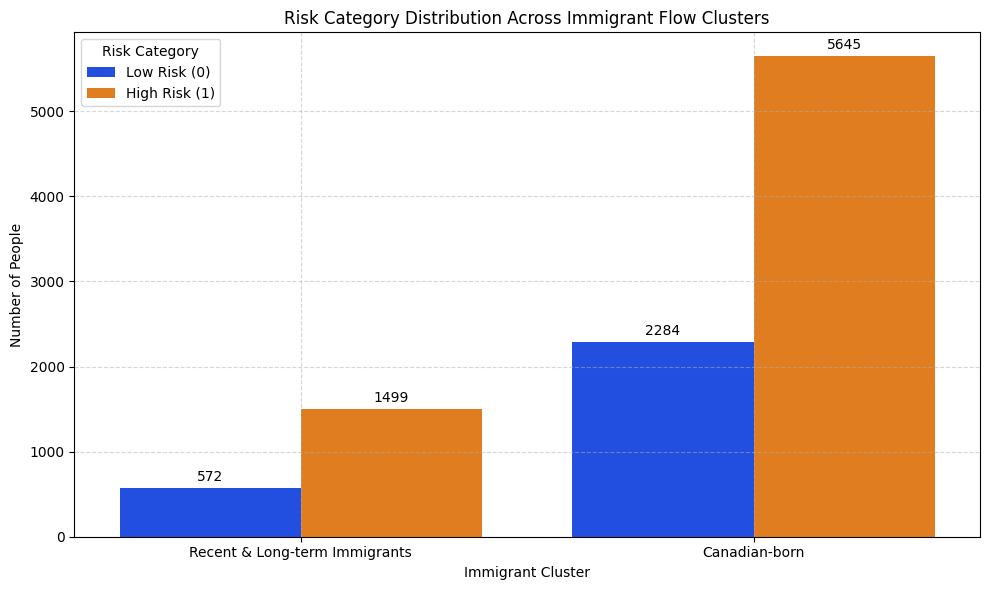

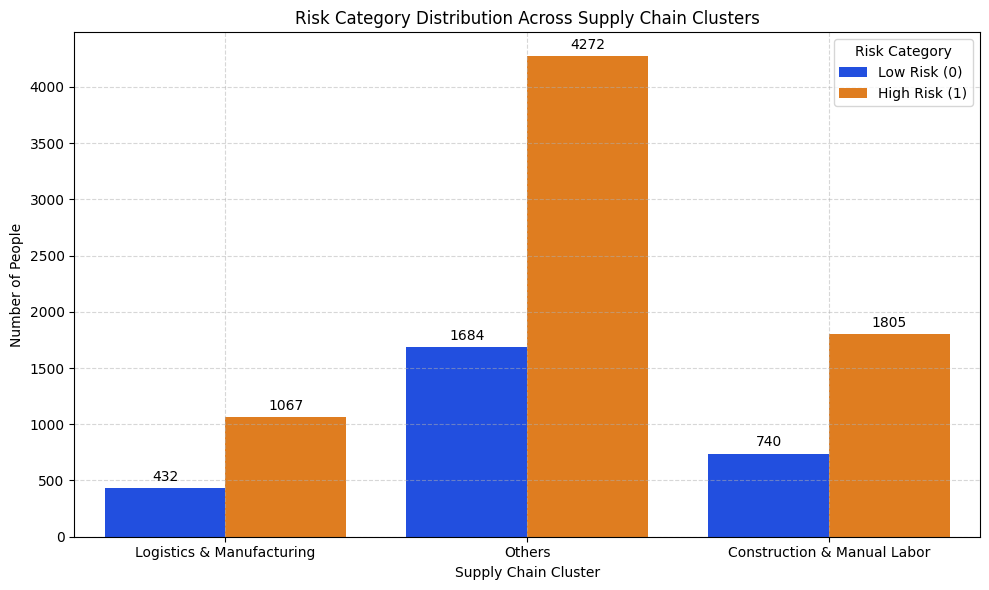

In [56]:
# Define mapping for descriptive labels
automation_cluster_labels = {
    1: 'Manual Labor',
    2: 'Tech',
    3: 'Finance, Education,\nRetail, Other',
    4: 'Manufacturing,\nConstruction,\nLogistics'
}

# Create a new column for plotting with descriptive labels
df_plot = df[df['cluster_job_automation'].notnull() & df['risk_category'].notnull()].copy()
df_plot['cluster_job_automation'] = df_plot['cluster_job_automation'].astype(int)
df_plot['risk_category'] = df_plot['risk_category'].astype(int)
df_plot['automation_label'] = df_plot['cluster_job_automation'].map(automation_cluster_labels)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_plot, x='automation_label', hue='risk_category', palette='bright')

# Annotate counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Labels and formatting
plt.title('Risk Category Distribution Across Job Automation Clusters')
plt.xlabel('Job Automation Cluster')
plt.ylabel('Number of People')
plt.legend(title='Risk Category', labels=['Low Risk (0)', 'High Risk (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Mapping for immigrant flow clusters
immigrant_cluster_labels = {
    1: 'Recent & Long-term Immigrants',
    2: 'Canadian-born'
}

# Prepare data
df_plot_immigrant = df[df['cluster_immigrant_flow'].notnull() & df['risk_category'].notnull()].copy()
df_plot_immigrant['cluster_immigrant_flow'] = df_plot_immigrant['cluster_immigrant_flow'].astype(int)
df_plot_immigrant['risk_category'] = df_plot_immigrant['risk_category'].astype(int)
df_plot_immigrant['immigrant_label'] = df_plot_immigrant['cluster_immigrant_flow'].map(immigrant_cluster_labels)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_plot_immigrant, x='immigrant_label', hue='risk_category', palette='bright')

# Annotate bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Risk Category Distribution Across Immigrant Flow Clusters')
plt.xlabel('Immigrant Cluster')
plt.ylabel('Number of People')
plt.legend(title='Risk Category', labels=['Low Risk (0)', 'High Risk (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Mapping for supply chain disruption clusters
supply_chain_cluster_labels = {
    1: 'Logistics & Manufacturing',
    2: 'Construction & Manual Labor',
    3: 'Others'
}

# Prepare data
df_plot_supply = df[df['cluster_supply_chain'].notnull() & df['risk_category'].notnull()].copy()
df_plot_supply['cluster_supply_chain'] = df_plot_supply['cluster_supply_chain'].astype(int)
df_plot_supply['risk_category'] = df_plot_supply['risk_category'].astype(int)
df_plot_supply['supply_chain_label'] = df_plot_supply['cluster_supply_chain'].map(supply_chain_cluster_labels)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_plot_supply, x='supply_chain_label', hue='risk_category', palette='bright')

# Annotate bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Risk Category Distribution Across Supply Chain Clusters')
plt.xlabel('Supply Chain Cluster')
plt.ylabel('Number of People')
plt.legend(title='Risk Category', labels=['Low Risk (0)', 'High Risk (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Scenario 1 - Automation Job Loss

In [57]:
# Make a copy of the original dataframe
df_stress = df.copy()

# -------------------------------
# Scenario 1: Job Loss Due to Automation
# -------------------------------

# Apply Income Changes
df_stress.loc[df_stress['cluster_job_automation'] == 1, 'annual_income'] *= 0.8   # Manual Workers: -20%
df_stress.loc[df_stress['cluster_job_automation'] == 2, 'annual_income'] *= np.random.uniform(1.10, 1.15)  # Tech Workers: +10% to +15%
df_stress.loc[df_stress['cluster_job_automation'] == 3, 'annual_income'] *= np.random.uniform(1.00, 1.05)  # White-Collar: 0% to +5%

# Apply Default Risk Changes via Delinquencies
df_stress.loc[df_stress['cluster_job_automation'] == 1, 'delinquencies_past_12mo'] *= 1.4   # Manual Workers: +40%
df_stress.loc[df_stress['cluster_job_automation'] == 2, 'delinquencies_past_12mo'] *= 0.8   # Tech Workers: -20%
df_stress.loc[df_stress['cluster_job_automation'] == 3, 'delinquencies_past_12mo'] *= 1.0   # White-Collar: stable

# Apply Employment Status Changes
# Manual Workers (Cluster 1): 20% of employed -> unemployed
manual_mask = (df_stress['cluster_job_automation'] == 1) & (df_stress['employment_status'] == 2)
manual_indices = df_stress[manual_mask].sample(frac=0.2, random_state=42).index
df_stress.loc[manual_indices, 'employment_status'] = 1  # Set to Unemployed

# Tech Workers (Cluster 2): 5% of unemployed -> employed
tech_mask = (df_stress['cluster_job_automation'] == 2) & (df_stress['employment_status'] == 1)
tech_indices = df_stress[tech_mask].sample(frac=0.05, random_state=42).index
df_stress.loc[tech_indices, 'employment_status'] = 2  # Set to Employed

# White-Collar and Others: No employment change



C:\Users\Maitreya\AppData\Local\Temp\ipykernel_13212\891773345.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.4 0.  0.  ... 0.  0.  0. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_stress.loc[df_stress['cluster_job_automation'] == 1, 'delinquencies_past_12mo'] *= 1.4   # Manual Workers: +40%


In [58]:
from sklearn.preprocessing import MinMaxScaler

# 1. Define features and weights
feature_weights = {
    'credit_score': 0.464346,
    'annual_income': 0.200716,
    'delinquencies_past_12mo': 0.091679,
    'assets': 0.077110,
    'net_worth': 0.026408,
    'total_liabilities': 0.022686,
    'liquid_assets': 0.016835,
    'total_value_of_open_loans': 0.013650,
    'monthly_payment': 0.009395,
    'credit_utilization': 0.008699,
    'property_value': 0.008436,
    'loan_to_value': 0.008394,
    'interest_rate': 0.008161,
    'mortgage_amount': 0.007628,
    'age': 0.006562,
    'total_years_employment': 0.006166,
    'mortgage_start_year': 0.005974,
    'years_with_current_employer': 0.004856,
    'number_of_open_loans': 0.004297,
    'industry_sector': 0.004179,
    'education_level': 0.003825,
    'employment_status': 0.001278
}

risk_features = list(feature_weights.keys())

# 2. Fill missing values (safeguard)
df_stress[risk_features] = df_stress[risk_features].fillna(0)

# 3. Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_stress[risk_features]), 
                         columns=risk_features, index=df_stress.index)

# 4. Compute risk score using dot product
weights_array = np.array(list(feature_weights.values()))
df_stress['risk_score'] = df_scaled[risk_features].dot(weights_array)

# 5. Assign risk category using threshold(s)
def assign_risk_category(score, high_threshold=0.5):
    return 'High Risk' if score > high_threshold else 'Low Risk'

# 6. Apply categorization
df_stress['risk_after_scen_1'] = df_stress['risk_score'].apply(assign_risk_category)

# Optional: Show value counts for quick validation
print(df_stress['risk_after_scen_1'].value_counts())



risk_after_scen_1
Low Risk     7060
High Risk    2940
Name: count, dtype: int64


C:\Users\Maitreya\AppData\Local\Temp\ipykernel_13212\1817838044.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_automation, x='risk_after_scen_1', palette='bright', order=['Low Risk', 'High Risk'])


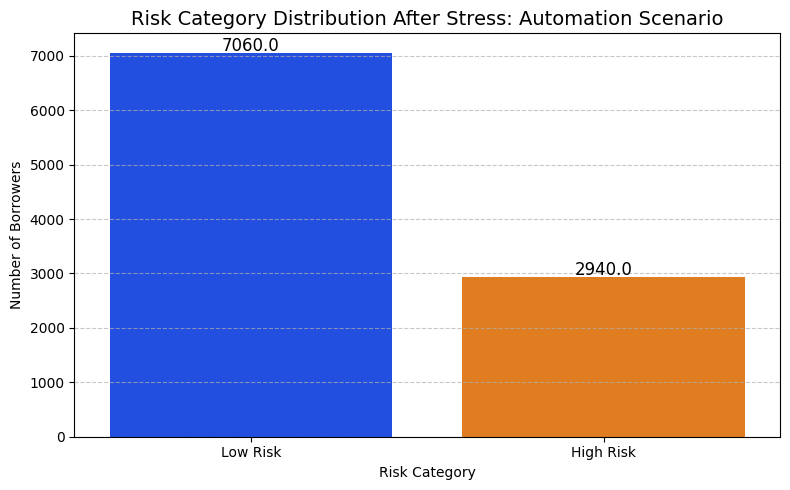

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only relevant automation clusters (manual, tech, white-collar/professional)
automation_clusters = [1, 2, 3, 4]
df_automation = df_stress[df_stress['cluster_job_automation'].isin(automation_clusters)]

# Plot risk category counts after stress (using the new risk category column)
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_automation, x='risk_after_scen_1', palette='bright', order=['Low Risk', 'High Risk'])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Risk Category Distribution After Stress: Automation Scenario', fontsize=14)
plt.xlabel('Risk Category')
plt.ylabel('Number of Borrowers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


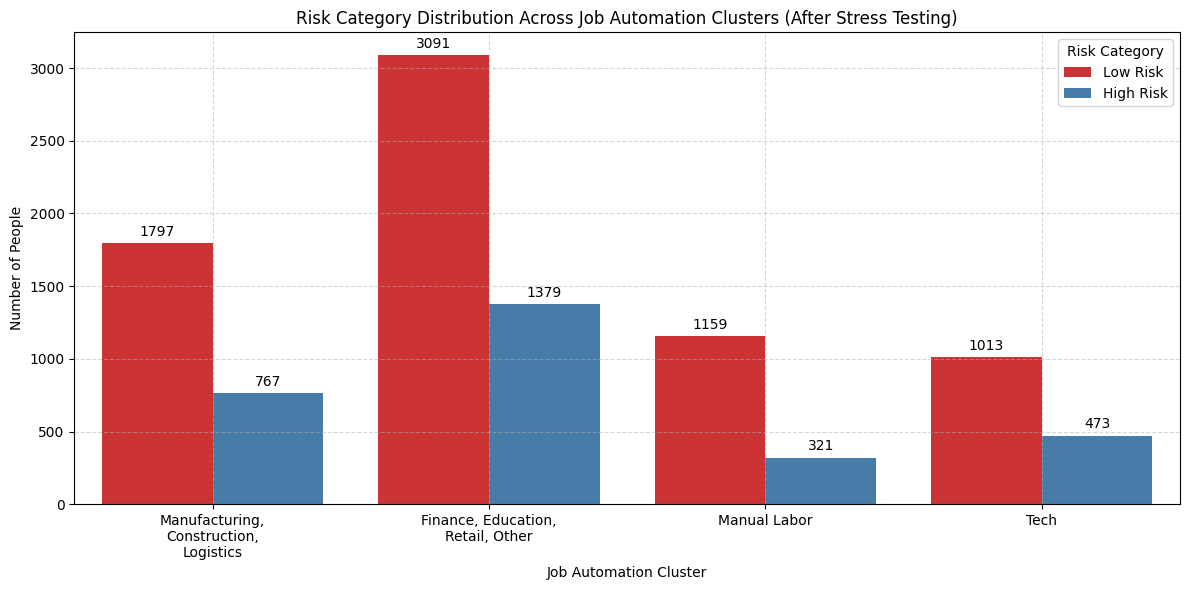

In [60]:
# Define mapping for descriptive labels
automation_cluster_labels = {
    1: 'Manual Labor',
    2: 'Tech',
    3: 'Finance, Education,\nRetail, Other',
    4: 'Manufacturing,\nConstruction,\nLogistics'
}

# Create new column for plotting with descriptive labels
df_plot_stress = df_stress[df_stress['cluster_job_automation'].notnull() & df_stress['risk_after_scen_1'].notnull()].copy()
df_plot_stress['cluster_job_automation'] = df_plot_stress['cluster_job_automation'].astype(int)
df_plot_stress['automation_label'] = df_plot_stress['cluster_job_automation'].map(automation_cluster_labels)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_plot_stress, x='automation_label', hue='risk_after_scen_1', palette='Set1')

# Annotate counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Labels and formatting
plt.title('Risk Category Distribution Across Job Automation Clusters (After Stress Testing)')
plt.xlabel('Job Automation Cluster')
plt.ylabel('Number of People')
plt.legend(title='Risk Category', labels=['Low Risk', 'High Risk'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Scenario 2 - Negative Scenario: Supply Chain Disruption 

In [62]:
# -------------------------------
# Scenario 2: Supply Chain Disruption
# -------------------------------

# Apply Income Changes
df_stress.loc[df_stress['cluster_supply_chain'] == 1, 'annual_income'] *= np.random.uniform(0.80, 0.85)   # Supply Chain Workers: -15% to -20%
df_stress.loc[df_stress['cluster_supply_chain'] == 2, 'annual_income'] *= np.random.uniform(1.00, 1.05)   # Non-Supply Chain Workers: No change

# Apply Default Risk Changes via Delinquencies
df_stress.loc[df_stress['cluster_supply_chain'] == 1, 'delinquencies_past_12mo'] *= np.random.uniform(1.20, 1.25)   # Supply Chain Workers: +20% to +25%
df_stress.loc[df_stress['cluster_supply_chain'] == 2, 'delinquencies_past_12mo'] *= np.random.uniform(1.15, 1.20)   # Non-Supply Chain Workers: +15% to +20%

# Apply Employment Status Changes
# Supply Chain Workers (Cluster 1): 20% of employed -> unemployed
supply_chain_mask = (df_stress['cluster_supply_chain'] == 1) & (df_stress['employment_status'] == 2)
supply_chain_indices = df_stress[supply_chain_mask].sample(frac=0.2, random_state=42).index
df_stress.loc[supply_chain_indices, 'employment_status'] = 1  # Set to Unemployed

# Non-Supply Chain Workers: Inflation on goods increase, Home prices rise, and labour income increase for construction workers
df_stress.loc[df_stress['cluster_supply_chain'] == 2, 'mortgage_amount'] *= 1.30  # Home Prices Increase: +30% mortgage_amount increase
df_stress.loc[df_stress['cluster_supply_chain'] == 2, 'mortgage_amount'] *= 1.05  # Inflation on goods: +5% mortgage_amount increase

# Apply Labour Income Increase for Construction Workers (e.g., Cluster 3: Construction, related workers)
df_stress.loc[df_stress['cluster_supply_chain'] == 3, 'annual_income'] *= 1.30  # Construction Workers: +30%

# Apply Interest Rates Increase for all Borrower Groups
df_stress['interest_rate'] += np.random.uniform(1.00, 2.00)  # Interest Rates Rise: +1% to +2%

# No employment status changes for Non-Supply Chain Workers

C:\Users\Maitreya\AppData\Local\Temp\ipykernel_13212\1065346641.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 492329.5  787062.9 1259753.3 ...  627138.2  848838.9 1284263.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_stress.loc[df_stress['cluster_supply_chain'] == 2, 'mortgage_amount'] *= 1.30  # Home Prices Increase: +30% mortgage_amount increase


In [63]:
from sklearn.preprocessing import MinMaxScaler

# 1. Define features and weights
feature_weights = {
    'credit_score': 0.464346,
    'annual_income': 0.200716,
    'delinquencies_past_12mo': 0.091679,
    'assets': 0.077110,
    'net_worth': 0.026408,
    'total_liabilities': 0.022686,
    'liquid_assets': 0.016835,
    'total_value_of_open_loans': 0.013650,
    'monthly_payment': 0.009395,
    'credit_utilization': 0.008699,
    'property_value': 0.008436,
    'loan_to_value': 0.008394,
    'interest_rate': 0.008161,
    'mortgage_amount': 0.007628,
    'age': 0.006562,
    'total_years_employment': 0.006166,
    'mortgage_start_year': 0.005974,
    'years_with_current_employer': 0.004856,
    'number_of_open_loans': 0.004297,
    'industry_sector': 0.004179,
    'education_level': 0.003825,
    'employment_status': 0.001278
}

risk_features = list(feature_weights.keys())

# 2. Fill missing values (safeguard)
df_stress[risk_features] = df_stress[risk_features].fillna(0)

# 3. Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_stress[risk_features]), 
                         columns=risk_features, index=df_stress.index)

# 4. Compute risk score using dot product
weights_array = np.array(list(feature_weights.values()))
df_stress['risk_score'] = df_scaled[risk_features].dot(weights_array)

# 5. Assign risk category using threshold(s)
def assign_risk_category(score, high_threshold=0.5):
    return 'High Risk' if score > high_threshold else 'Low Risk'

# 6. Apply categorization
df_stress['risk_after_scen_2'] = df_stress['risk_score'].apply(assign_risk_category)

# Optional: Show value counts for quick validation
print(df_stress['risk_after_scen_2'].value_counts())



risk_after_scen_2
Low Risk     7433
High Risk    2567
Name: count, dtype: int64


C:\Users\Maitreya\AppData\Local\Temp\ipykernel_13212\1233048371.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_automation, x='risk_after_scen_2', palette='bright', order=['Low Risk', 'High Risk'])


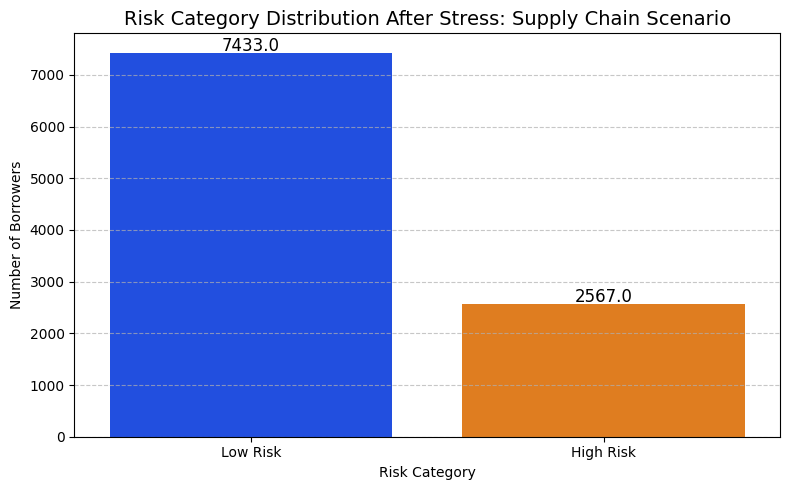

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only relevant automation clusters (manual, tech, white-collar/professional)
automation_clusters = [1, 2, 3]
df_automation = df_stress[df_stress['cluster_supply_chain'].isin(automation_clusters)]

# Plot risk category counts after stress (using the new risk category column)
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_automation, x='risk_after_scen_2', palette='bright', order=['Low Risk', 'High Risk'])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Risk Category Distribution After Stress: Supply Chain Scenario', fontsize=14)
plt.xlabel('Risk Category')
plt.ylabel('Number of Borrowers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


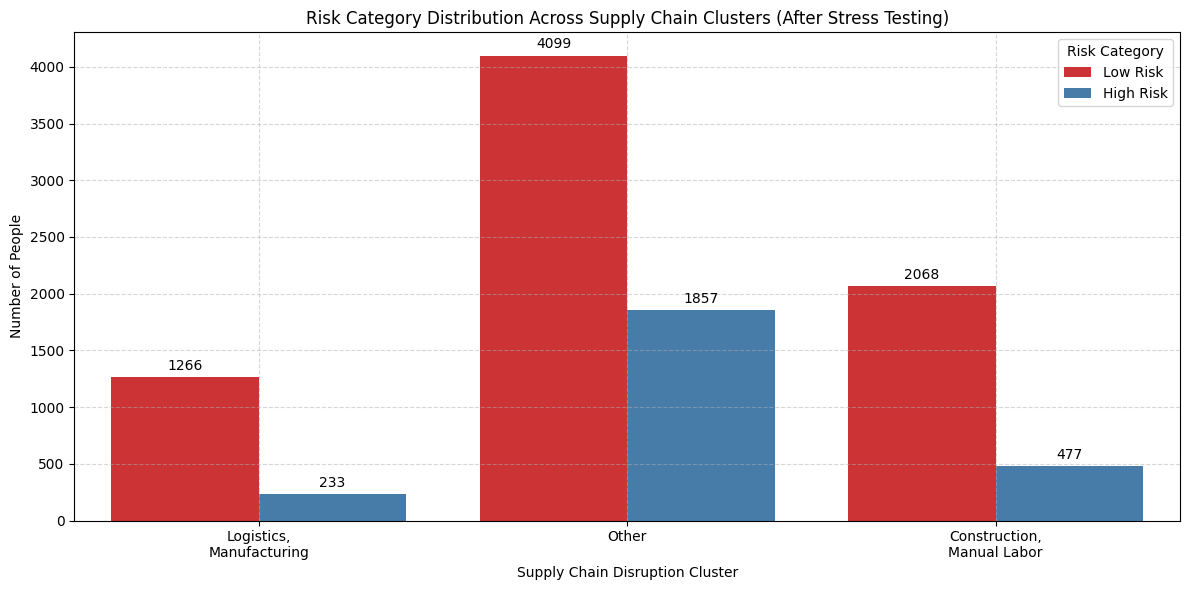

In [68]:
# Define mapping for descriptive labels
supply_chain_label = {
    1: 'Logistics,\nManufacturing',
    2: 'Construction,\nManual Labor',
    3: 'Other',
}

# Create new column for plotting with descriptive labels
df_plot_stress = df_stress[df_stress['cluster_supply_chain'].notnull() & df_stress['risk_after_scen_2'].notnull()].copy()

# Convert to integer and map labels for supply chain cluster
df_plot_stress['cluster_supply_chain'] = df_plot_stress['cluster_supply_chain'].astype(int)
df_plot_stress['supply_chain_label'] = df_plot_stress['cluster_supply_chain'].map(supply_chain_label)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_plot_stress, x='supply_chain_label', hue='risk_after_scen_2', palette='Set1')

# Annotate counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Labels and formatting
plt.title('Risk Category Distribution Across Supply Chain Clusters (After Stress Testing)')
plt.xlabel('Supply Chain Disruption Cluster')
plt.ylabel('Number of People')
plt.legend(title='Risk Category', labels=['Low Risk', 'High Risk'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
